In [1]:
#Task5—Linear regression modeling attempt

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# mport data and preprocessing
df = pd.read_csv("merged_dataset.csv")

In [2]:
# No need for deprecated option settings
# pd.set_option('future.no_silent_downcasting', True)
for col in [f"Bubble_BP{i}" for i in range(1, 8)] + ["Bubble_BV1"]:
    df[col] = df[col].replace({"No": 0, "Yes": 1}).astype(int)

In [3]:
# Extraction of features (same as original code)
def extract_statistical_features(df):
    features = []
    grouped = df.groupby("Case#")
    
    for cid, group in grouped:
        row = {"Case#": cid}
        for p in [f"P{i}" for i in range(1, 8)]:
            row[f"{p}_mean"] = group[p].mean()
            row[f"{p}_std"] = group[p].std()
            row[f"{p}_min"] = group[p].min()
            row[f"{p}_max"] = group[p].max()
        row["Spacecraft#"] = group["Spacecraft#"].iloc[0]
        features.append(row)

    return pd.DataFrame(features)

# Extract tags (same as original code)
def extract_labels(df):
    case_ids = df["Case#"].unique()
    label_dict = {}
    for cid in case_ids:
        d = df[df["Case#"] == cid].iloc[0]
        task1 = 0 if d["Condition"].lower() == "normal" else 1

        if task1 == 0:
            task2, task3, task4, task5 = 0, 0, 0, 100.0
        else:
            if d[[f"Bubble_BP{i}" for i in range(1, 8)] + ["Bubble_BV1"]].sum() > 0:
                task2 = 2
                task3 = np.argmax(d[[f"Bubble_BP{i}" for i in range(1, 8)] + ["Bubble_BV1"]].values) + 1
                task4 = 0
                task5 = 100.0
            elif d[[f"Opening_Ratio_SV{i}" for i in range(1, 5)]].min() < 100:
                task2 = 3
                sv_values = [d[f"Opening_Ratio_SV{i}"] for i in range(1, 5)]
                task4 = np.argmin(sv_values) + 1
                task5 = float(min(sv_values))
            else:
                task2, task3, task4, task5 = 1, 0, 0, 100.0

        label_dict[cid] = {
            "task1": task1,
            "task2": task2,
            "task3": task3,
            "task4": task4,
            "task5": task5
        }
    return label_dict

label_dict = extract_labels(df)
features_df = extract_statistical_features(df)


In [4]:
# Task 5：Prediction of faulty solenoid valve openings (using linear regression)
# Filter out samples of solenoid valve failures
features_df["task2"] = [label_dict[cid]["task2"] for cid in features_df["Case#"]]
features_df["task5"] = [label_dict[cid]["task5"] for cid in features_df["Case#"]]

# Training the opening prediction model using only the case of solenoid valve failure
sv_fault_df = features_df[features_df["task2"] == 3].copy()

if len(sv_fault_df) > 0:
    X_sv = sv_fault_df.drop(columns=["Case#", "task2", "task5"])
    y_sv = sv_fault_df["task5"].values
    
    # If the dataset is too small, you can use leave-one-out cross-validation
    if len(sv_fault_df) > 10:
        # Use 80% of the data for training
        X_train, X_test, y_train, y_test = train_test_split(
            X_sv, y_sv, test_size=0.2, random_state=42
        )
        
        # Prediction using linear regression
        linear_regressor = LinearRegression()
        linear_regressor.fit(X_train, y_train)
        
        # Evaluate on a test set
        y_pred = linear_regressor.predict(X_test)
        
        # Calculation of assessment indicators
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print("[Task 5 - Linear Regression]")
        print(f"mean square error (MSE): {mse:.4f}")
        print(f"root mean square error (RMSE): {rmse:.4f}")
        print(f"Mean absolute error (MAE): {mae:.4f}")
        print(f"coefficient of determination (R^2): {r2:.4f}")

[Task 5 - Linear Regression]
mean square error (MSE): 2026.4802
root mean square error (RMSE): 45.0164
Mean absolute error (MAE): 34.9206
coefficient of determination (R^2): -1.0139


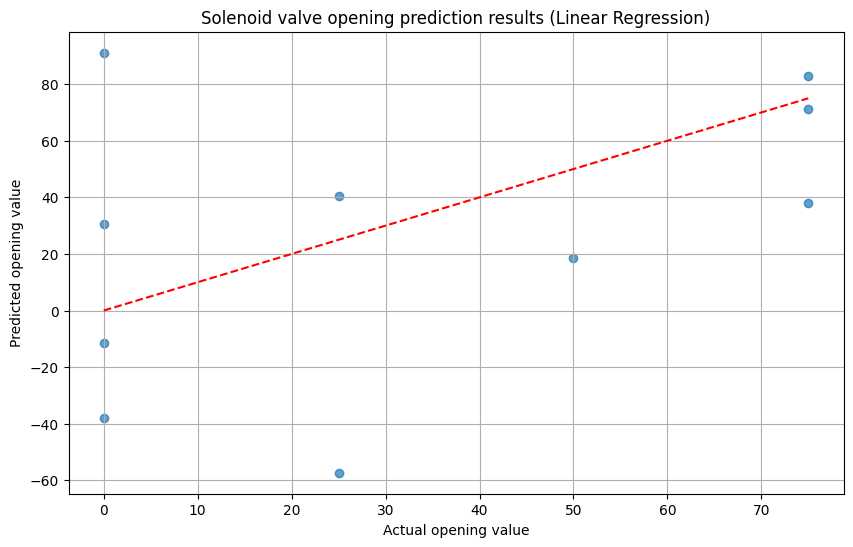

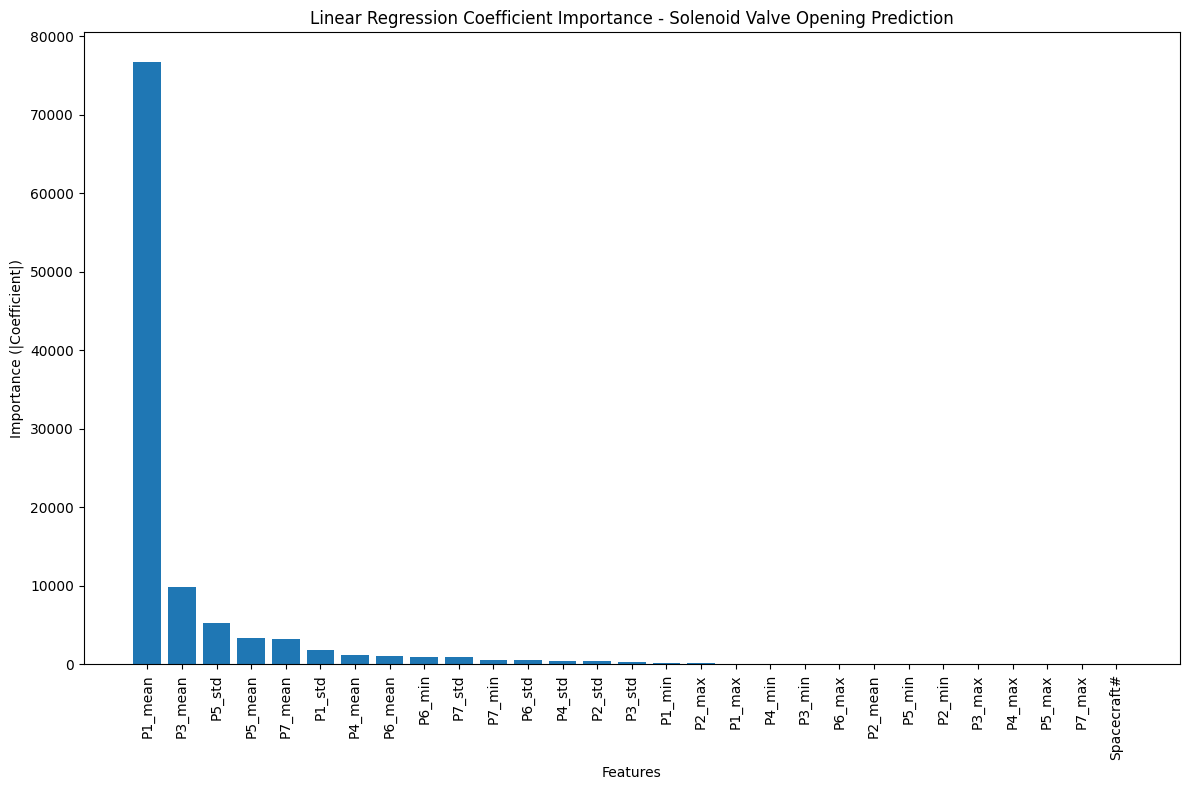

The model has been saved as 'linear_valve_opening_regressor.joblib'


In [5]:
# Plotting predicted versus actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual opening value')
plt.ylabel('Predicted opening value')
plt.title('Solenoid valve opening prediction results (Linear Regression)')
plt.grid(True)
plt.savefig('valve_opening_prediction_linear.png')
plt.show()
        
# Characteristic significance (for linear regression, use the absolute value of the coefficients as the characteristic significance)
importance = np.abs(linear_regressor.coef_)
feature_names = X_train.columns
        
# Sort feature importance in descending order
indices = np.argsort(importance)[::-1]
        
plt.figure(figsize=(12, 8))
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance (|Coefficient|)')
plt.title('Linear Regression Coefficient Importance - Solenoid Valve Opening Prediction')
plt.tight_layout()
plt.savefig('feature_importance_linear.png')
plt.show()
        
# Saving model
import joblib
joblib.dump(linear_regressor, 'linear_valve_opening_regressor.joblib')
print("The model has been saved as 'linear_valve_opening_regressor.joblib'")

In [6]:
# Examine the most influential features in the model
print("\nCharacteristics with the greatest impact:")
for i in range(min(5, len(indices))):
    idx = indices[i]  
    print(f"{feature_names[idx]}: {importance[idx]:.4f}") 


Characteristics with the greatest impact:
P1_mean: 76644.2950
P3_mean: 9884.0866
P5_std: 5269.2507
P5_mean: 3317.3854
P7_mean: 3193.0272
